In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.classical import expr   # allows classical logic on mid circuit measurement
def get_ghz_circ_dynamic(num_qubit):   
    if num_qubit%2==1:                                                  # For odd number of qubits
        qr=QuantumRegister(num_qubit)
        num_mid_measurements=int(num_qubit/2)
        cr1=ClassicalRegister(num_mid_measurements,name="cr1")          # mid circuit measurement
        cr2=ClassicalRegister(num_qubit,name="cr2")                     # final measurement
        qc=QuantumCircuit(qr,cr1,cr2)
        for i in range(num_mid_measurements+1):
            qc.h(2*i)
        qc.barrier()
        for i in range(num_mid_measurements):
            qc.cx(2*i+2,2*i+1)
            qc.cx(2*i,2*i+1)
        qc.barrier()
        for i in range(num_mid_measurements):
            qc.measure(2*i+1,cr1[i])
            if i==0:
                parity=expr.lift(cr1[i])
            else :
                parity=expr.bit_xor(cr1[i],parity)
            with qc.if_test(parity):
                    qc.x(2*i+2)
    
        for i in range(num_mid_measurements):
            parity=expr.lift(cr1[i])
            with qc.if_test(parity):
                qc.x(2*i+1)
            qc.cx(2*i,2*i+1)

    else:                                                               # For even number of Qubits
        qr=QuantumRegister(num_qubit)
        num_mid_measurements=int((num_qubit-1)/2)
        cr1=ClassicalRegister(num_mid_measurements,name="cr1")          # mid circuit measurement
        cr2=ClassicalRegister(num_qubit,name="cr2")                     # final measurement
        qc=QuantumCircuit(qr,cr1,cr2)
        for i in range(num_mid_measurements+1):
            qc.h(2*i)
        
        for i in range(num_mid_measurements):
            qc.cx(2*i+2,2*i+1)
            qc.cx(2*i,2*i+1)
        
        for i in range(num_mid_measurements):
            qc.measure(2*i+1,cr1[i])
            if i==0:
                parity=expr.lift(cr1[i])
            else :
                parity=expr.bit_xor(cr1[i],parity)
            with qc.if_test(parity):
                    qc.x(2*i+2)
    
        for i in range(num_mid_measurements):
            parity=expr.lift(cr1[i])
            with qc.if_test(parity):
                qc.x(2*i+1)
            qc.cx(2*i,2*i+1)
        qc.cx(num_qubit-2,num_qubit-1)
    for i in range(num_qubit):
        qc.measure(qr[i],cr2[i])
    return qc


In [2]:
def get_ghz_circ_static(num_qubit):
    if num_qubit%2==1:                                                     #odd no of qubits
        qr=QuantumRegister(num_qubit)
        cr2=ClassicalRegister(num_qubit,name="cr2")                     
        qc=QuantumCircuit(qr,cr2)
        mid_qubit_index=int((num_qubit-1)/2)
        qc.h(mid_qubit_index)
        for i in range(mid_qubit_index,num_qubit-1):
            qc.cx(i,i+1)
            qc.cx(num_qubit-i-1,num_qubit-i-2)
        
    else:                                                                    #even no of qubits
        qr=QuantumRegister(num_qubit)
        cr2=ClassicalRegister(num_qubit,name="cr2")                     
        qc=QuantumCircuit(qr,cr2)
        mid_qubit_index=int((num_qubit-2)/2)
        qc.h(mid_qubit_index)
        for i in range(mid_qubit_index,num_qubit-2):
            qc.cx(i,i+1)
            qc.cx(num_qubit-1-i-1,num_qubit-i-3)
        qc.cx(num_qubit-2,num_qubit-1)
    for i in range(num_qubit):
        qc.measure(qr[i],cr2[i])
    return qc
    
    

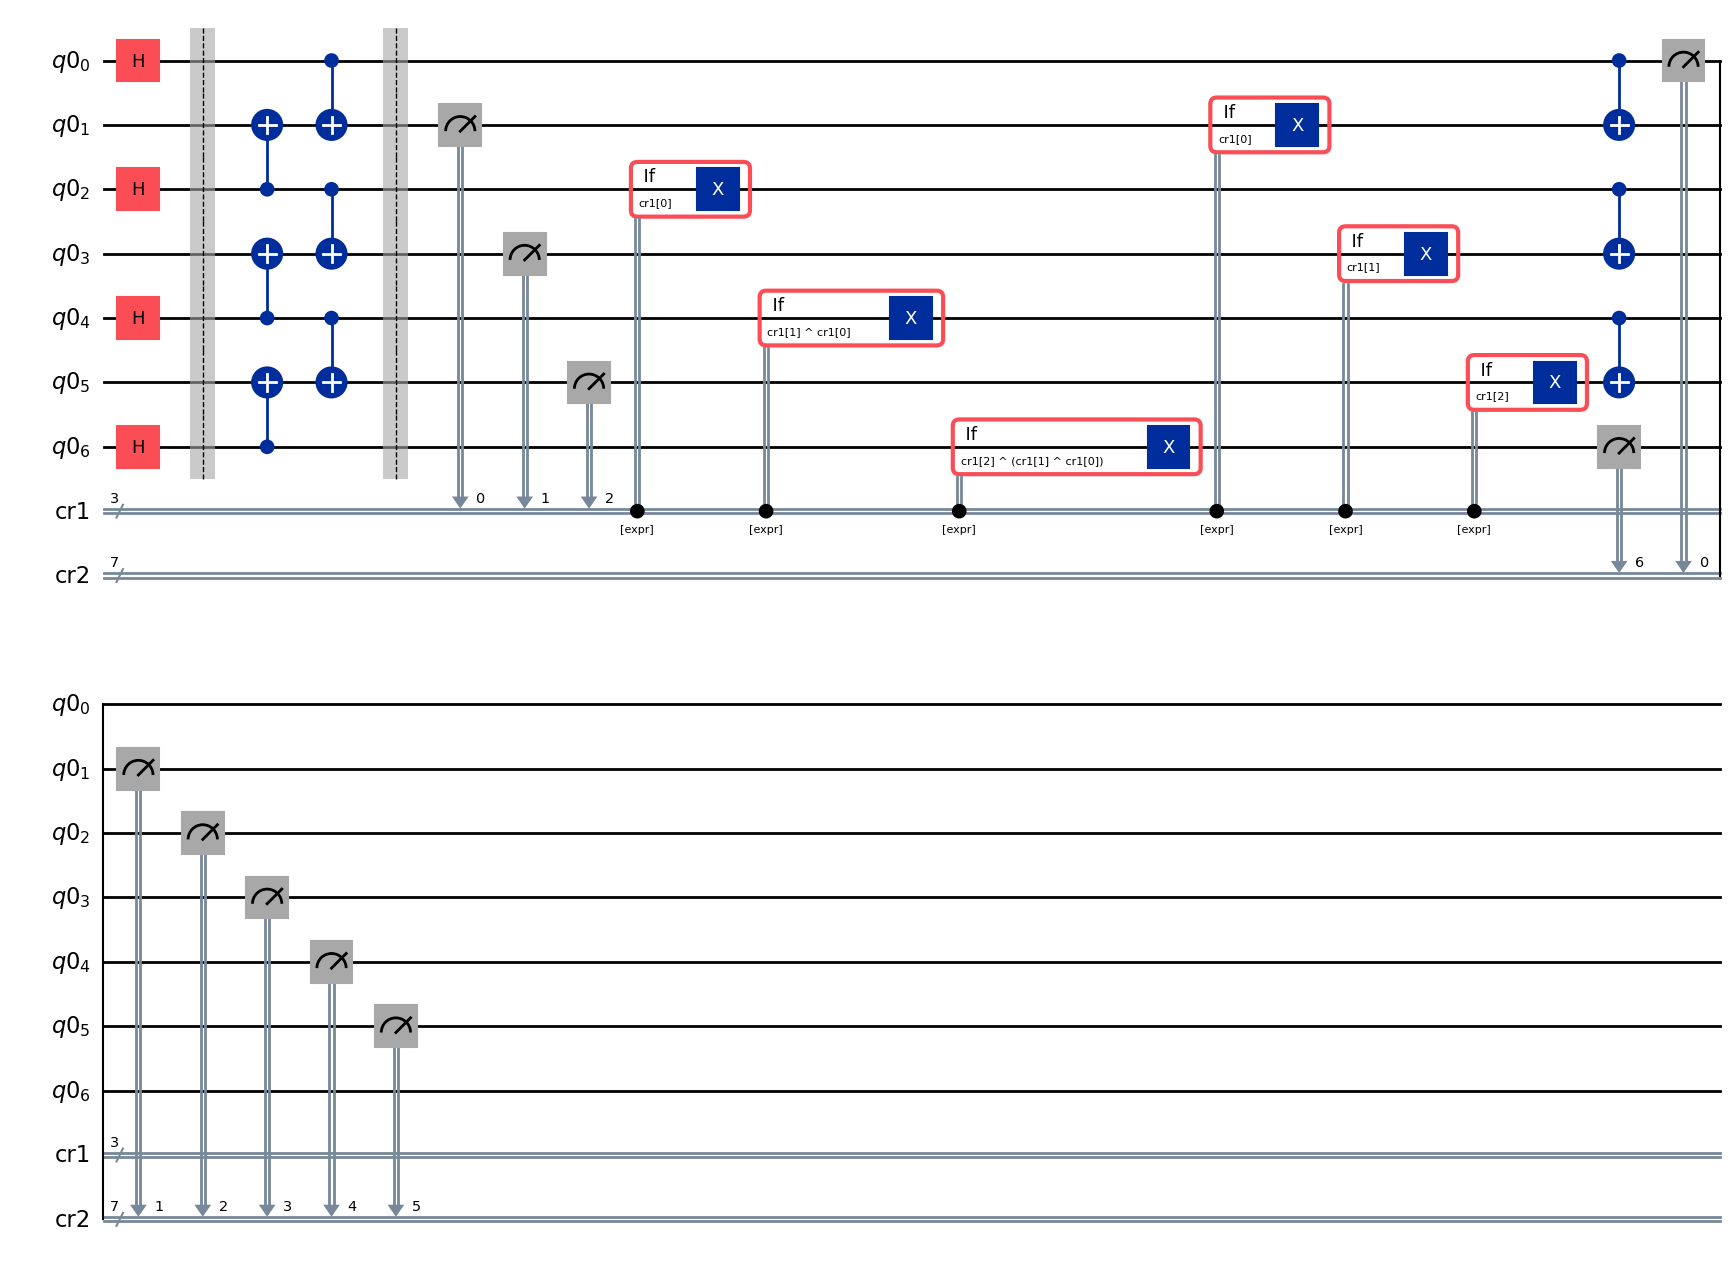

In [3]:
qc = get_ghz_circ_dynamic(num_qubit=7)
qc.draw("mpl")

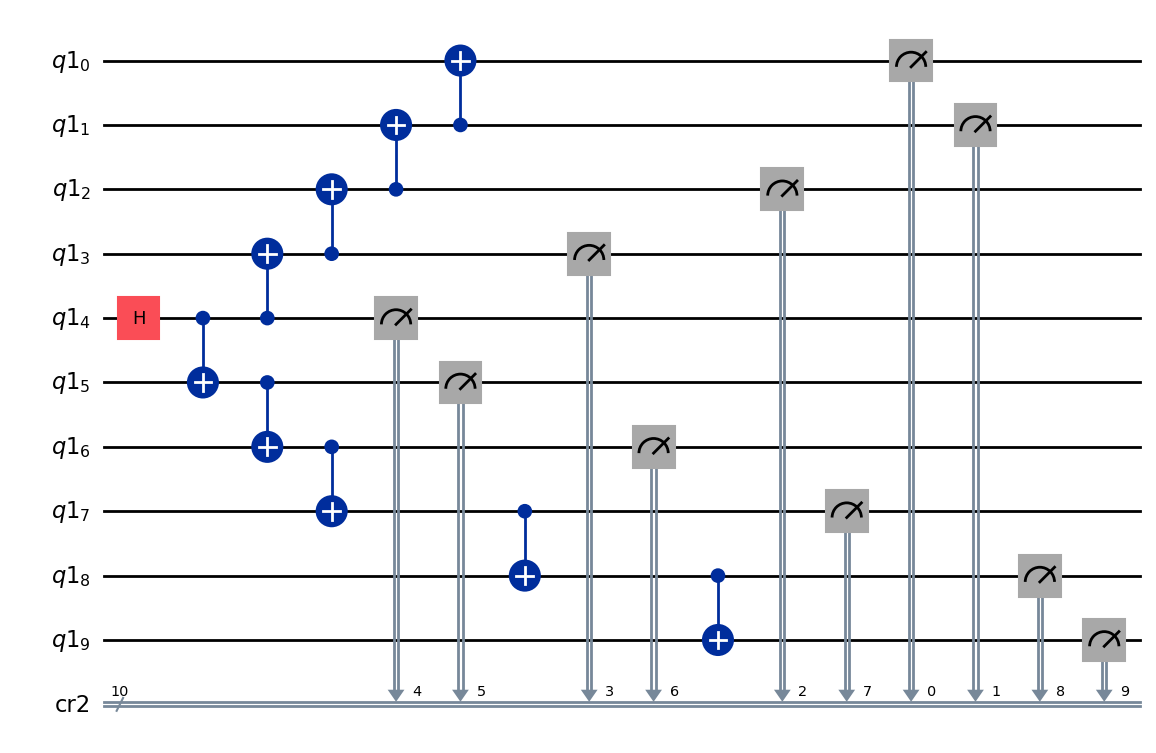

In [4]:
qc = get_ghz_circ_static(num_qubit=10)
qc.draw("mpl")

In [5]:
#Creating list of circuits [Static1, Dynamic1, Static1, Dyanmic1,...,static2,dynamic2,staic2,dynamic2,...] i.e. some copies of each of them
min_qubit=10
max_num_qubit=12
copies=2
#qc_list_dynamic=[]
#qc_list_static=[]
#observables=[]
qc_list=[]
num_qubit_list=[]
for i in range(min_qubit,max_num_qubit+1):
    num_qubit_list.append(i)
for num_qubit in num_qubit_list:
    for i in range(copies):
        qc_list.append(get_ghz_circ_static(num_qubit))
        qc_list.append(get_ghz_circ_dynamic(num_qubit))

In [6]:
#Ideal Simulation with AerSimulator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
 
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
qc_transpiled_list=[]



qc_transpiled_list_ideal = pm.run(qc_list)



In [7]:
sampler = Sampler(backend=aer_sim)
result_ideal = sampler.run(qc_transpiled_list_ideal).result()

In [8]:
# For getting list of ideal counts (argument required for Fidelity)
counts_list_ideal=[]
for i in range(len(num_qubit_list)):  
    for j in range(copies):
        data_static = result_ideal[(2*i*copies)+(2*j)].data
        data_dynamic = result_ideal[(2*i*copies)+((2*j)+1)].data
        counts_static=data_static.cr2.get_counts()
        counts_dynamic=data_dynamic.cr2.get_counts()
        counts_list_ideal.append(counts_static)
        counts_list_ideal.append(counts_dynamic)

In [9]:
# Simulation of real hardware to get result_real
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
 
 
service = QiskitRuntimeService()
 
# Specify a system to use for the noise model
real_backend = service.backend("ibm_brisbane")
aer = AerSimulator.from_backend(real_backend)
 
# Run the sampler job locally using AerSimulator.
pm = generate_preset_pass_manager(backend=aer, optimization_level=1)
qc_transpiled_list_real = pm.run(qc_list)
sampler = Sampler(backend=aer)
result_brisbane = sampler.run(qc_transpiled_list_real).result()

In [10]:
# Simulation of real hardware to get result_real
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
 
 
service = QiskitRuntimeService()
 
# Specify a system to use for the noise model
real_backend = service.backend("ibm_sherbrooke")
aer = AerSimulator.from_backend(real_backend)
 
# Run the sampler job locally using AerSimulator.
pm = generate_preset_pass_manager(backend=aer, optimization_level=1)
qc_transpiled_list_real = pm.run(qc_list)
sampler = Sampler(backend=aer)
result_sherbrooke = sampler.run(qc_transpiled_list_real).result()

In [11]:
# Simulation of real hardware to get result_real
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
 
 
service = QiskitRuntimeService()
 
# Specify a system to use for the noise model
real_backend = service.backend("ibm_osaka")
aer = AerSimulator.from_backend(real_backend)
 
# Run the sampler job locally using AerSimulator.
pm = generate_preset_pass_manager(backend=aer, optimization_level=1)
qc_transpiled_list_real = pm.run(qc_list)                               
sampler = Sampler(backend=aer)
result_osaka = sampler.run(qc_transpiled_list_real).result()

In [12]:
# Simulation of real hardware to get result_real
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
 
 
service = QiskitRuntimeService()
 
# Specify a system to use for the noise model
real_backend = service.backend("ibm_kyoto")
aer = AerSimulator.from_backend(real_backend)
 
# Run the sampler job locally using AerSimulator.
pm = generate_preset_pass_manager(backend=aer, optimization_level=1)
qc_transpiled_list_real = pm.run(qc_list)                                
sampler = Sampler(backend=aer)
result_kyoto = sampler.run(qc_transpiled_list_real).result()

In [13]:
#get list counts_list_brisbane, counts_list_sherbrooke, counts_list_osaka, counts_list_kyoto (argument required for Fidelity)
counts_list_brisbane=[]
counts_list_sherbrooke=[]
counts_list_osaka=[]
counts_list_kyoto=[]
for i in range(len(num_qubit_list)):  
    for j in range(copies):
        data_static = result_brisbane[(2*i*copies)+(2*j)].data
        data_dynamic = result_brisbane[(2*i*copies)+((2*j)+1)].data
        counts_static=data_static.cr2.get_counts()
        counts_dynamic=data_dynamic.cr2.get_counts()
        counts_list_brisbane.append(counts_static)
        counts_list_brisbane.append(counts_dynamic)

        data_static = result_sherbrooke[(2*i*copies)+(2*j)].data
        data_dynamic = result_sherbrooke[(2*i*copies)+((2*j)+1)].data
        counts_static=data_static.cr2.get_counts()
        counts_dynamic=data_dynamic.cr2.get_counts()
        counts_list_sherbrooke.append(counts_static)
        counts_list_sherbrooke.append(counts_dynamic)

        data_static = result_osaka[(2*i*copies)+(2*j)].data
        data_dynamic = result_osaka[(2*i*copies)+((2*j)+1)].data
        counts_static=data_static.cr2.get_counts()
        counts_dynamic=data_dynamic.cr2.get_counts()
        counts_list_osaka.append(counts_static)
        counts_list_osaka.append(counts_dynamic)

        data_static = result_kyoto[(2*i*copies)+(2*j)].data
        data_dynamic = result_kyoto[(2*i*copies)+((2*j)+1)].data
        counts_static=data_static.cr2.get_counts()
        counts_dynamic=data_dynamic.cr2.get_counts()
        counts_list_kyoto.append(counts_static)
        counts_list_kyoto.append(counts_dynamic)


In [14]:
#Calculation of lists of Fidelity mean and std deviation of all 4 hardware simulation
import statistics
from qiskit.quantum_info.analysis import hellinger_fidelity
# We will create 4 lists of Fidelities, for storing mean, std deviation of Fidelity, of copies of a circuit for fixed no of logical qubits
# For GHZ state analysis: index 0 of these lists store informationn of GHZ state having 3 qubits, index 1 for 4 qubits and so on 
Fidelity_mean_static_brisbane=[]
Fidelity_mean_dynamic_brisbane=[]
Fidelity_std_static_brisbane=[]
Fidelity_std_dynamic_brisbane=[]
Fidelity_copies_static_brisbane=[]
Fidelity_copies_dynamic_brisbane=[]

Fidelity_mean_static_sherbrooke=[]
Fidelity_mean_dynamic_sherbrooke=[]
Fidelity_std_static_sherbrooke=[]
Fidelity_std_dynamic_sherbrooke=[]
Fidelity_copies_static_sherbrooke=[]
Fidelity_copies_dynamic_sherbrooke=[]

Fidelity_mean_static_osaka=[]
Fidelity_mean_dynamic_osaka=[]
Fidelity_std_static_osaka=[]
Fidelity_std_dynamic_osaka=[]
Fidelity_copies_static_osaka=[]
Fidelity_copies_dynamic_osaka=[]

Fidelity_mean_static_kyoto=[]
Fidelity_mean_dynamic_kyoto=[]
Fidelity_std_static_kyoto=[]
Fidelity_std_dynamic_kyoto=[]
Fidelity_copies_static_kyoto=[]
Fidelity_copies_dynamic_kyoto=[]
for i in range(len(num_qubit_list)):
    
    for j in range(copies):
        
        Fidelity_static= hellinger_fidelity(counts_list_ideal[(2*i*copies)+(2*j)], counts_list_brisbane[(2*i*copies)+(2*j)])
        Fidelity_dynamic=hellinger_fidelity(counts_list_ideal[(2*i*copies)+((2*j)+1)], counts_list_brisbane[(2*i*copies)+((2*j)+1)])
        Fidelity_copies_static_brisbane.append(Fidelity_static)
        Fidelity_copies_dynamic_brisbane.append(Fidelity_dynamic)

        Fidelity_static= hellinger_fidelity(counts_list_ideal[(2*i*copies)+(2*j)], counts_list_sherbrooke[(2*i*copies)+(2*j)])
        Fidelity_dynamic=hellinger_fidelity(counts_list_ideal[(2*i*copies)+((2*j)+1)], counts_list_sherbrooke[(2*i*copies)+((2*j)+1)])
        Fidelity_copies_static_sherbrooke.append(Fidelity_static)
        Fidelity_copies_dynamic_sherbrooke.append(Fidelity_dynamic)

        Fidelity_static= hellinger_fidelity(counts_list_ideal[(2*i*copies)+(2*j)], counts_list_osaka[(2*i*copies)+(2*j)])
        Fidelity_dynamic=hellinger_fidelity(counts_list_ideal[(2*i*copies)+((2*j)+1)], counts_list_osaka[(2*i*copies)+((2*j)+1)])
        Fidelity_copies_static_osaka.append(Fidelity_static)
        Fidelity_copies_dynamic_osaka.append(Fidelity_dynamic)

        Fidelity_static= hellinger_fidelity(counts_list_ideal[(2*i*copies)+(2*j)], counts_list_kyoto[(2*i*copies)+(2*j)])
        Fidelity_dynamic=hellinger_fidelity(counts_list_ideal[(2*i*copies)+((2*j)+1)], counts_list_kyoto[(2*i*copies)+((2*j)+1)])
        Fidelity_copies_static_kyoto.append(Fidelity_static)
        Fidelity_copies_dynamic_kyoto.append(Fidelity_dynamic)

    
    Fidelity_mean_static_brisbane.append(statistics.mean(Fidelity_copies_static_brisbane))
    Fidelity_mean_dynamic_brisbane.append(statistics.mean(Fidelity_copies_dynamic_brisbane))
    Fidelity_std_static_brisbane.append(statistics.stdev(Fidelity_copies_static_brisbane))
    Fidelity_std_dynamic_brisbane.append(statistics.stdev(Fidelity_copies_dynamic_brisbane))
    Fidelity_copies_static_brisbane.clear()
    Fidelity_copies_dynamic_brisbane.clear()

    Fidelity_mean_static_sherbrooke.append(statistics.mean(Fidelity_copies_static_sherbrooke))
    Fidelity_mean_dynamic_sherbrooke.append(statistics.mean(Fidelity_copies_dynamic_sherbrooke))
    Fidelity_std_static_sherbrooke.append(statistics.stdev(Fidelity_copies_static_sherbrooke))
    Fidelity_std_dynamic_sherbrooke.append(statistics.stdev(Fidelity_copies_dynamic_sherbrooke))
    Fidelity_copies_static_sherbrooke.clear()
    Fidelity_copies_dynamic_sherbrooke.clear()

    Fidelity_mean_static_osaka.append(statistics.mean(Fidelity_copies_static_osaka))
    Fidelity_mean_dynamic_osaka.append(statistics.mean(Fidelity_copies_dynamic_osaka))
    Fidelity_std_static_osaka.append(statistics.stdev(Fidelity_copies_static_osaka))
    Fidelity_std_dynamic_osaka.append(statistics.stdev(Fidelity_copies_dynamic_osaka))
    Fidelity_copies_static_osaka.clear()
    Fidelity_copies_dynamic_osaka.clear()

    Fidelity_mean_static_kyoto.append(statistics.mean(Fidelity_copies_static_kyoto))
    Fidelity_mean_dynamic_kyoto.append(statistics.mean(Fidelity_copies_dynamic_kyoto))
    Fidelity_std_static_kyoto.append(statistics.stdev(Fidelity_copies_static_kyoto))
    Fidelity_std_dynamic_kyoto.append(statistics.stdev(Fidelity_copies_dynamic_kyoto))
    Fidelity_copies_static_kyoto.clear()
    Fidelity_copies_dynamic_kyoto.clear()

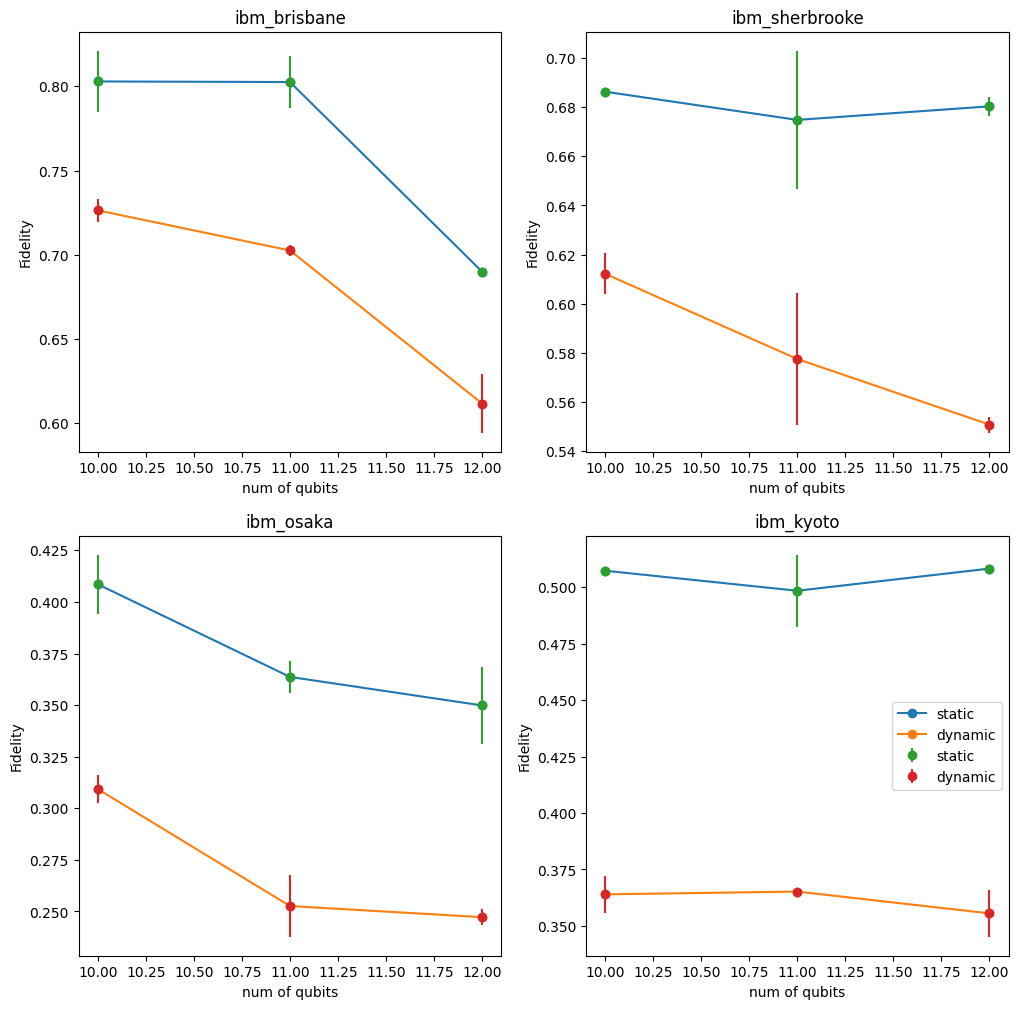

In [15]:
# Graph plotting
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
#figure(figsize=(16,12), dpi=180)
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12,12))
# Create  data.

ax1.set_xlabel('num of qubits')
ax1.set_ylabel('Fidelity')
ax1.set_title('ibm_brisbane')
x1 = num_qubit_list
y1_static = Fidelity_mean_static_brisbane
y1_dynamic = Fidelity_mean_dynamic_brisbane
y_error_static =Fidelity_std_static_brisbane
y_error_dynamic =Fidelity_std_dynamic_brisbane
ax1.plot(x1, y1_static, 'o-',label='Static')
ax1.plot(x1, y1_dynamic, 'o-',label='dynamic')
ax1.errorbar(x1, y1_static,
			yerr = y_error_static, label='static',
			fmt ='o')
ax1.errorbar(x1, y1_dynamic,
			yerr = y_error_dynamic, label='dynamic',
			fmt ='o')

ax2.set_xlabel('num of qubits')
ax2.set_ylabel('Fidelity')
ax2.set_title('ibm_sherbrooke')
x2 = num_qubit_list
y2_static = Fidelity_mean_static_sherbrooke
y2_dynamic = Fidelity_mean_dynamic_sherbrooke
ax2.plot(x2, y2_static, 'o-',label='static')
ax2.plot(x2, y2_dynamic, 'o-',label='dynamic')
y_error_static =Fidelity_std_static_sherbrooke
y_error_dynamic =Fidelity_std_dynamic_sherbrooke
ax2.errorbar(x2, y2_static,
			yerr = y_error_static, label='static',
			fmt ='o')
ax2.errorbar(x2, y2_dynamic,
			yerr = y_error_dynamic, label='dynamic',
			fmt ='o')

ax3.set_xlabel('num of qubits')
ax3.set_ylabel('Fidelity')
ax3.set_title('ibm_osaka')
x3 = num_qubit_list
y3_static = Fidelity_mean_static_osaka
y3_dynamic = Fidelity_mean_dynamic_osaka
ax3.plot(x3, y3_static ,'o-',label='static')
ax3.plot(x3, y3_dynamic ,'o-',label='dynamic')
y_error_static =Fidelity_std_static_osaka
y_error_dynamic =Fidelity_std_dynamic_osaka
ax3.errorbar(x3, y3_static,
			yerr = y_error_static, label='static',
			fmt ='o')
ax3.errorbar(x3, y3_dynamic,
			yerr = y_error_dynamic, label='dynamic',
			fmt ='o')

ax4.set_xlabel('num of qubits')
ax4.set_ylabel('Fidelity')
ax4.set_title('ibm_kyoto')
x4 = num_qubit_list
y4_static = Fidelity_mean_static_kyoto
y4_dynamic = Fidelity_mean_dynamic_kyoto
ax4.plot(x4, y4_static ,'o-',label='static')
ax4.plot(x4, y4_dynamic, 'o-',label='dynamic')
y_error_static =Fidelity_std_static_kyoto
y_error_dynamic =Fidelity_std_dynamic_kyoto
ax4.errorbar(x4, y4_static,
			yerr = y_error_static, label='static',
			fmt ='o')
ax4.errorbar(x4, y4_dynamic,
			yerr = y_error_dynamic, label='dynamic',
			fmt ='o')


plt.legend()
plt.show()